# ECON 325: An Example of Final Project
* **Author**: The COMET Team (Shiming Wu, Rathin Dharani, Jonathan Graves)
* **Last Updated**: 26 August 2022

## Outline

This notebook is an example of what a "final project" might look like in ECON 325.  It summarizes and uses all of the empirical skills and R commands present in the other notebooks.  

If you are reviewing the materials from ECON 325, or self-studying it, this is a good self-test to see if you understand all of the material.  After completing this course, you should be able to:

* Read this notebook, and understand what the difference analyses are, and how they are being used
* Critique the choices made, understanding their pros and cons
* Understand what the R code is doing, and how it implements the analyses
* Be able to describe how to adjust or change this to do other analysis or change the focus or assumptions made in the analysis so far

You can also use this as a model of a project of your own, if you're interested in getting started with econometric analysis.


## Education, Career and Inequality

In [1]:
## load the packages

library(tidyverse)
library(haven)
library(ggplot2)
library(stargazer)

Warning message in system("timedatectl", intern = TRUE):
“running command 'timedatectl' had status 1”
── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.5     ✔ purrr   0.3.4
✔ tibble  3.1.6     ✔ dplyr   1.0.7
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.2     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()


Please cite as: 


 Hlavac, Marek (2022). stargazer: Well-Formatted Regression and Summary Statistics Tables.

 R package version 5.2.3. https://CRAN.R-project.org/package=stargazer 




### Notes

<span id="fn2">[<sup>1</sup>](#fn2s)Stargazer package is due to: Hlavac, Marek (2022). stargazer: Well-Formatted Regression and Summary Statistics Tables.
 R package version 5.2.3. https://CRAN.R-project.org/package=stargazer </span>

## Introduction
Getting a university degree can be tough. We may wonder whether higher education level can help us to achieve a more successful career. Besides, is education the only factor that impacts our career? In this project, we are going to answer these questions. Since one of the important proxies for a successful career is income, we are going to study the relationship between education, income, and wealth.

Now, let's first import our data and clean our dataset. For this project, we will be using data from the 2019 Survey of Financial Security (SFS), provided by Statistics Canada (see the license notes). This is real Canadian data in 2019. The survey was conducted by household unit, so income and wealth variables represent total income and wealth from a family, and household characteristics are usually the characteristics of main earners in the household. The main earner is the person who has highest income in a family. In order to study career outcomes, we restrict our samples to be households whose major sources of incomes are wages, salaries and self-employment incomes.

In [2]:
# READING IN DATA
SFS_data <- read_dta("../datasets/SFS_2019_Eng.dta")

# FILTERING OUT NA VALUES FOR TARGET VARIABLES
SFS_data <- filter(SFS_data, !is.na(SFS_data$pefmtinc))
SFS_data <- filter(SFS_data, !is.na(SFS_data$pefatinc))
SFS_data <- filter(SFS_data, !is.na(SFS_data$pwnetwpg))
SFS_data <- filter(SFS_data, !is.na(SFS_data$pagemieg))

# SUBSETTING DATA 
SFS_data <- subset(SFS_data, pefmjsif == "02" | pefmjsif == "03") 
# restrict samples to be households whose major sources of incomes are wages, salaries and self-employment incomes.

# RENAMING VARIABLES TO READABLE NAMES
SFS_data <- rename(SFS_data, income_before_tax = pefmtinc)
SFS_data <- rename(SFS_data, income_after_tax = pefatinc)
SFS_data <- rename(SFS_data, wealth = pwnetwpg)
SFS_data <- rename(SFS_data, gender = pgdrmie)
SFS_data <- rename(SFS_data, education = peducmie)
SFS_data <- rename(SFS_data, business = pbusind)
SFS_data <- rename(SFS_data, province = ppvres)
SFS_data <- rename(SFS_data, credit_limit = pattlmlc)
SFS_data <- rename(SFS_data, age = pagemieg)
SFS_data <- rename(SFS_data, employment = plffptme)

# REFACTORING SOME VARIABLES
SFS_data<-SFS_data[!(SFS_data$education=="9"),] # remove observations that education is "not stated"
SFS_data$education <- as.numeric(SFS_data$education)
SFS_data <- SFS_data[order(SFS_data$education),] # sort dataset by variable `education`
SFS_data$education <- as.character(SFS_data$education)
SFS_data$education[SFS_data$education == "1"] <- "Less than high school" 
# replace content to be 'less than high school' if orginal content is '1' for variable education
SFS_data$education[SFS_data$education == "2"] <- "High school"
SFS_data$education[SFS_data$education == "3"] <- "Non-university post-secondary"
SFS_data$education[SFS_data$education == "4"] <- "University"

# CHANGING ALL CATEGORICAL VARIABLES TO FACTOR VARIABLES (originally they were string variables)
SFS_data$gender <- as_factor(SFS_data$gender)
SFS_data$education <- as_factor(SFS_data$education)
SFS_data$business <- as_factor(SFS_data$business)
SFS_data$province <- as_factor(SFS_data$province)
SFS_data$age <- as_factor(SFS_data$age)
SFS_data$employment <- as_factor(SFS_data$employment)

Since we want to study income, let's restrict the sample to main working groups, mostly are people with age 25 to 65. The age variable we use is the age of main earner in a household.

In [3]:
SFS_data <- 
        SFS_data %>%
        mutate(agegr = case_when(
              age == "01" ~ "Under 30", #under 20
              age == "02" ~ "Under 30", #20-24
              age == "03" ~ "20s", #25-29
              age == "04" ~ "30s",
            age == "05" ~ "30s",
              age == "06" ~ "40s",
              age == "07" ~ "40s",
              age == "08" ~ "50s",
              age == "09" ~ "50s",
              age == "10" ~ "60s", #60-64
              age == "11" ~ "Above 65", #65-69
              age == "12" ~ "Above 65", #70-74
              age == "13" ~ "Above 75", #75-79
              age == "14" ~ "Above 75", #80 and above
              )) %>%
        mutate(agegr = as_factor(agegr))

SFS_data <- subset(SFS_data, agegr == "20s" | agegr == "30s" | agegr == "40s" | agegr == "50s" | agegr == "60s" )
SFS_data$agegr <- factor(SFS_data$agegr,levels = c("20s", "30s", "40s", "50s", "60s"))

## Summary Statistics
Before we begin our exploration, let's first describe variables of interest. Variables incomes and wealth are of the family unit. The wealth variable represents net worth of the family unit. Mean of income before tax of a family in 2019 is about \$124,804.5. The standard deviation of income after tax is smaller than income before tax, which suggests tax and government transfers reduce income inequality in Canada. Net wealth of a family unit is approximately 9.5 times of the income after tax of a family. Unlike income after tax, standard deviation of wealth is large, thus dispersion of wealth is larger than income, which conforms with economic literature.

In [4]:
df <- data.frame(variables=c('income before tax','income after tax','wealth'),
                 mean=round(c(mean(SFS_data$income_before_tax),mean(SFS_data$income_after_tax),mean(SFS_data$wealth)),2),
                 median=round(c(median(SFS_data$income_before_tax),median(SFS_data$income_after_tax),median(SFS_data$wealth)),2),
                sd=round(c(sd(SFS_data$income_before_tax),sd(SFS_data$income_after_tax),sd(SFS_data$wealth)),2))

df 
# question: can you do this using summarize instead?

variables,mean,median,sd
<chr>,<dbl>,<dbl>,<dbl>
income before tax,124804.5,100000,130976.38
income after tax,104293.8,91325,82879.99
wealth,951819.9,502000,1449619.85


Since `age` and `education` are factor variables, we can visualize them with histograms. As we can see from the graph below, many main earners are in their 50s, and most main earners have a post-secondary degree.

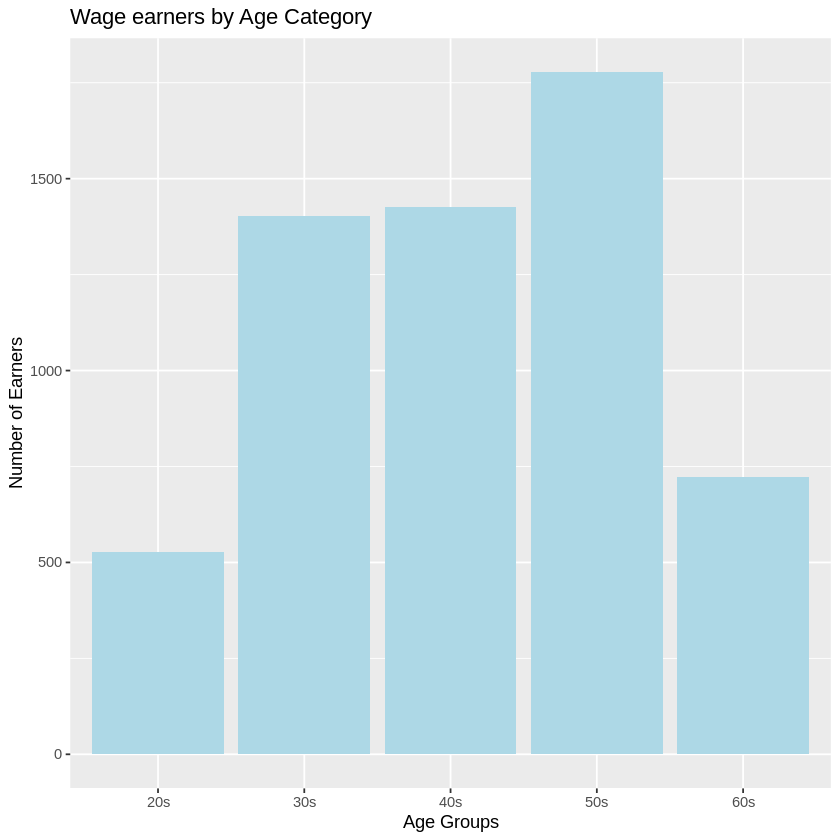

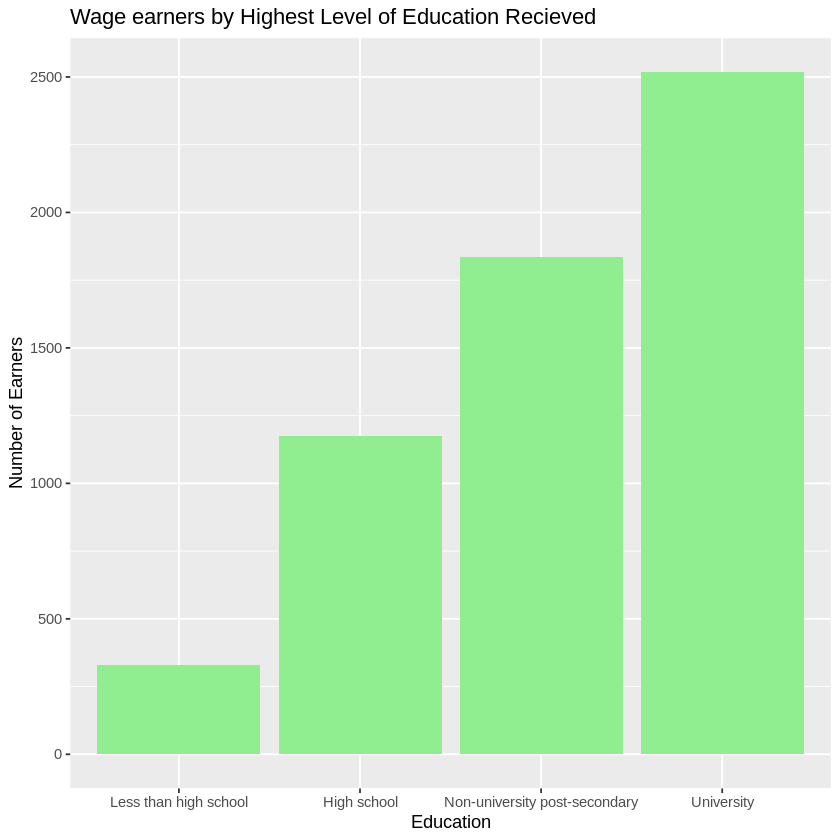

In [10]:
age_plot<-ggplot(SFS_data, aes(x=agegr)) + 
          geom_bar(fill="lightblue") + 
          ggtitle("Wage earners by Age Category") +
          ylab("Number of Earners")+
          xlab("Age Groups") 
options(repr.plot.width=7,repr.plot.height=7) #set size of the plot
edu_plot<-ggplot(SFS_data, aes(x=education)) +
          geom_bar(fill="lightgreen") + 
          ggtitle("Wage earners by Highest Level of Education Recieved") +
          ylab("Number of Earners") +
          xlab("Education") 
age_plot
edu_plot

Now let's remove outliers to preclude effects of extreme values. We remove observations which lies in highest 2% and lowest 2% of incomes and wealth. Both incomes and wealth are right-skewed: they have long right tails.

In [11]:
# FINDS THE LOWER AND UPPER BOUND SPECIFIED 
pct2_income_before <- quantile(SFS_data$income_before_tax,c(0.02,0.98),type=1)

# FILTERS OUT THE VALUES OUTSIDE OF THE BOUNDS SPECIFIED
SFS_data <- filter(SFS_data, SFS_data$income_before_tax > pct2_income_before[1] & SFS_data$income_before_tax < pct2_income_before[2])

pct2_income_after <- quantile(SFS_data$income_after_tax,c(0.02,0.98),type=1)
SFS_data <- filter(SFS_data, SFS_data$income_after_tax > pct2_income_after[1] & SFS_data$income_after_tax < pct2_income_after[2])

pct2_wealth <- quantile(SFS_data$wealth,c(0.02,0.98),type=1)
SFS_data <- filter(SFS_data, SFS_data$wealth > pct2_wealth[1] & SFS_data$wealth < pct2_wealth[2])

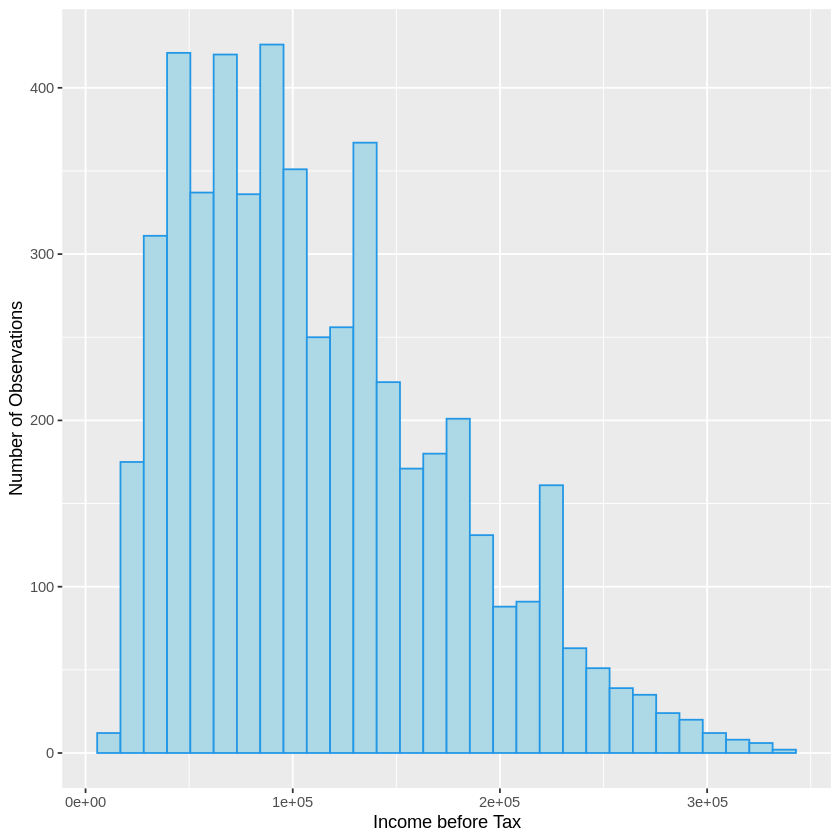

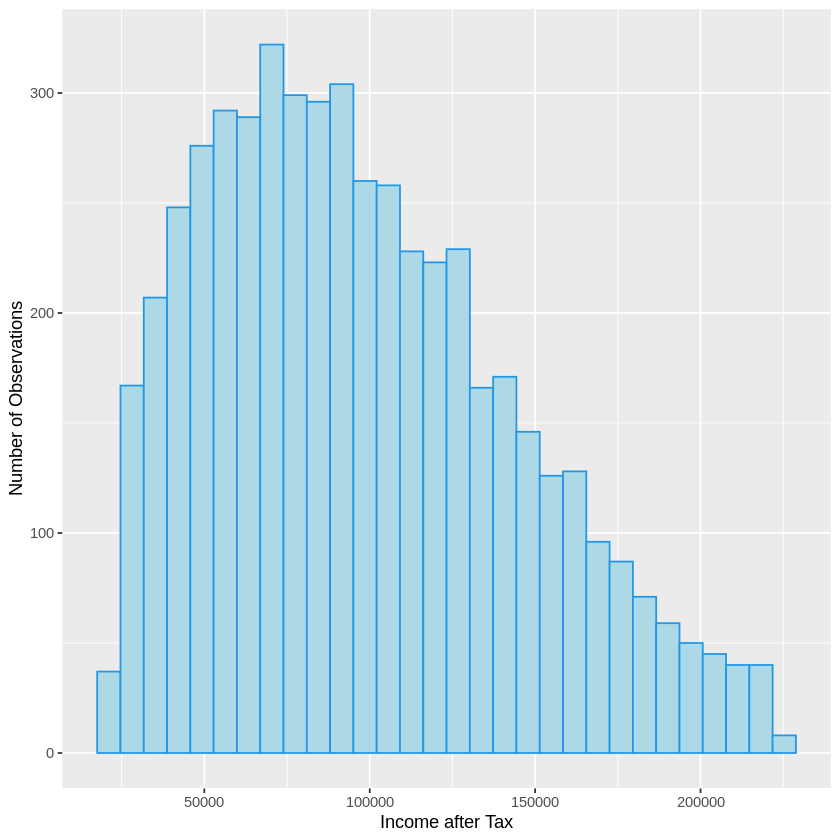

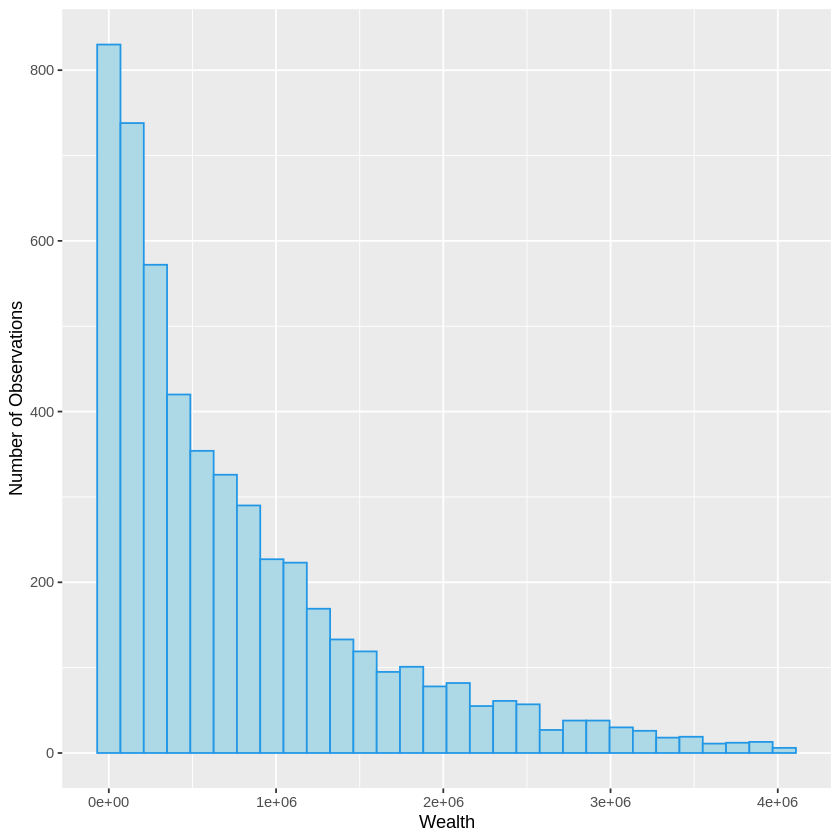

In [12]:
options(repr.plot.width=7,repr.plot.height=7)

income_before_tax_plot<-ggplot(SFS_data, aes(x=income_before_tax)) + geom_histogram(colour = 4, fill = "lightblue", 
                 bins = 30)  + xlab("Income before Tax") + ylab("Number of Observations") + scale_x_continuous()
income_after_tax_plot<-ggplot(SFS_data, aes(x=income_after_tax)) + geom_histogram(colour = 4, fill = "lightblue", 
                 bins = 30)  + xlab("Income after Tax") + ylab("Number of Observations") + scale_x_continuous()

income_before_tax_plot
income_after_tax_plot

wealth_plot<-ggplot(SFS_data, aes(x=wealth)) + geom_histogram(colour = 4, fill = "lightblue", 
                 bins = 30)  + xlab("Wealth") + ylab("Number of Observations") + scale_x_continuous()
wealth_plot



## Education and Career
Now let's study the relationship between education, income and wealth. First we create a function `CI` to calculate confidence interval. And then we store the mean of income and wealth by groups of education in table `results`. We use the `CI` function to calculate confidence intervals and combine results in table `df_gr`. We also display results in graphs.

From table `df_gr`, we notice that incomes and wealth increase as education increases. Thus education does help us to achieve a more successful career. Meanwhile, standard deviations also increase as education increases. This implies income and wealth inequality increase as education increases. From a personal point of view, in order to have a successful career, obtaining a degree is just a starting point. Career development is also crucial for a successful career. From a policy perspective, policies that only target pre-labor market skill accumulation will be less effective. We will need policies that foster career progression to reduce inequality.

In [13]:
CI <- function(data) {
    x <- mean(data) # calculate mean of input
    n <- length(data) # calculate number of observations
    df <- n - 1 # degree of freedom is n-1
    t <- qt(p = 0.05, df = df) # finding the t value for a confidence level of 95% 
    s <- sd(data) # finding the sample standard deviation of input
    
    # calculating the lower and upper bounds of the desired confidence interval
    lower_bound <- x - (t*s/sqrt(n))
    upper_bound <- x + (t*s/sqrt(n))
    
    bound<-c(lower_bound,upper_bound) # store lower bound and upper bound to a vector named `bound`
    return(bound)
}

In [14]:
'Generate a Dataframe to Display Summary Statistics by Education Groups'

#First, we create a table named `results` to store mean and standard deviations of incomes and wealth by education groups
results <- 
    SFS_data %>% 
    group_by(education) %>%
    summarize(m_income = mean(income_before_tax), sd_income = sd(income_before_tax),
              m_wealth = mean(wealth), sd_wealth = sd(wealth))

#Next, we make a dataframe named `df_gr` to display mean, standard deviations and confidence intervals of incomes and wealth.
#The first 3 columns of `df_gr` are from table `results`, which contain names of education groups, mean and standard deviations of incomes.
#The 4th column of `df_gr` is lower bound of CI of incomes.
#We obtain `CI_L_income` by running function `CI` with inputs of incomes of each group.
#For example, we filter out people with `Less than high school` degree and input their `income_before_tax` in `CI` function.
#The second element of output in `CI` function is lower bound, while the first element is upper bound.
#Similarly, we perform the same procedure for `wealth`.
df_gr <- data.frame(results[1],results[2],results[3],
                 CI_L_income=c(CI(filter(SFS_data, education == "Less than high school")$income_before_tax)[2],
                               CI(filter(SFS_data, education == "High school")$income_before_tax)[2],
                               CI(filter(SFS_data, education == "Non-university post-secondary")$income_before_tax)[2],
                               CI(filter(SFS_data, education == "University")$income_before_tax)[2]),
                CI_U_income=c(CI(filter(SFS_data, education == "Less than high school")$income_before_tax)[1],
                              CI(filter(SFS_data, education == "High school")$income_before_tax)[1],
                              CI(filter(SFS_data, education == "Non-university post-secondary")$income_before_tax)[1],
                              CI(filter(SFS_data, education == "University")$income_before_tax)[1]),
                 results[4],results[5],
                 CI_L_wealth=c(CI(filter(SFS_data, education == "Less than high school")$wealth)[2],
                               CI(filter(SFS_data, education == "High school")$wealth)[2],
                               CI(filter(SFS_data, education == "Non-university post-secondary")$wealth)[2],
                               CI(filter(SFS_data, education == "University")$wealth)[2]),
                CI_U_wealth=c(CI(filter(SFS_data, education == "Less than high school")$wealth)[1],
                              CI(filter(SFS_data, education == "High school")$wealth)[1],
                              CI(filter(SFS_data, education == "Non-university post-secondary")$wealth)[1],
                              CI(filter(SFS_data, education == "University")$wealth)[1]))

df_gr

[1] "Generate a Dataframe to Display Summary Statistics by Education Groups"

education,m_income,sd_income,CI_L_income,CI_U_income,m_wealth,sd_wealth,CI_L_wealth,CI_U_wealth
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Less than high school,81239.44,49818.33,76360.99,86117.88,420790.0,491730.0,372637.5,468942.5
High school,94789.79,54371.99,92050.78,97528.81,624052.8,709126.7,588330.2,659775.4
Non-university post-secondary,105596.85,57741.74,103280.45,107913.26,666605.4,729836.6,637326.8,695883.9
University,132165.26,67358.58,129765.25,134565.27,976124.9,910465.0,943684.7,1008565.1


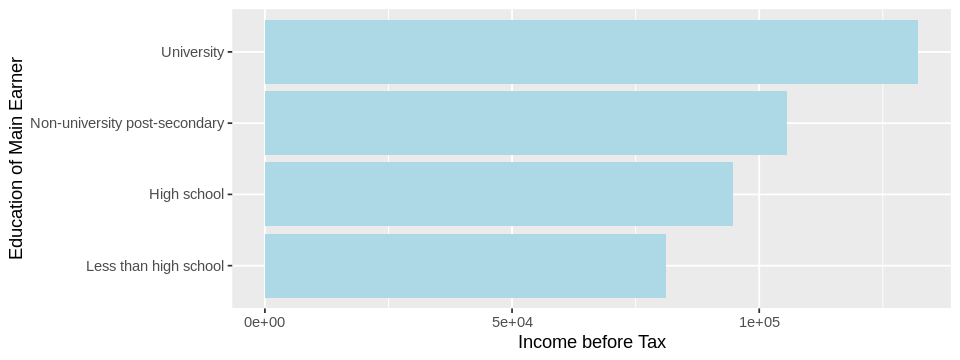

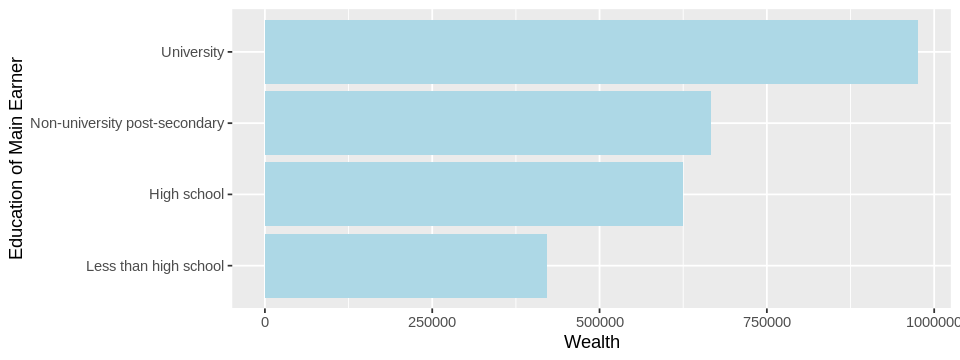

In [15]:
options(repr.plot.width=8,repr.plot.height=3)
g <- ggplot(data = SFS_data, aes(x = education, y = income_before_tax)) + xlab("Education of Main Earner") + ylab("Income before Tax") + scale_y_continuous() 
g1 <- g + geom_bar(stat = "summary", fun = "mean", fill = "lightblue") #produce a summary statistic, the mean
g1 <- g1 + coord_flip() #make a horizontal bar graph!

f <- ggplot(data = SFS_data, aes(x = education, y = wealth)) + xlab("Education of Main Earner") + ylab("Wealth") + scale_y_continuous() 
f1 <- f + geom_bar(stat = "summary", fun = "mean", fill = "lightblue") #produce a summary statistic, the mean
f1 <- f1 + coord_flip() #make a horizontal bar graph!

g1
f1

From table and graphs above, we know incomes and wealth of different education groups are different. But is the difference statistically significant? We use two sample t-test to verify the results. 

The t-tests for income and wealth are significant. The results suggest people who obtain university degrees will have higher wages and wealth than people who own non-university post-secondary degrees.

In [16]:
t1 = t.test(
       x = filter(SFS_data, education == "Non-university post-secondary")$income_before_tax,
       y = filter(SFS_data, education == "University")$income_before_tax,
       alternative = "two.sided",
       mu = 0,
       conf.level = 0.95)

t1 

round(t1$estimate[1] - t1$estimate[2],2) 


	Welch Two Sample t-test

data:  filter(SFS_data, education == "Non-university post-secondary")$income_before_tax and filter(SFS_data, education == "University")$income_before_tax
t = -13.108, df = 3787.9, p-value < 2.2e-16
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 -30542.26 -22594.56
sample estimates:
mean of x mean of y 
 105596.9  132165.3 


mean of x 
-26568.41

In [17]:
t2 = t.test(
       x = filter(SFS_data, education == "Non-university post-secondary")$wealth,
       y = filter(SFS_data, education == "University")$wealth,
       alternative = "two.sided",
       mu = 0,
       conf.level = 0.95)

t2 

round(t2$estimate[1] - t2$estimate[2],2) 


	Welch Two Sample t-test

data:  filter(SFS_data, education == "Non-university post-secondary")$wealth and filter(SFS_data, education == "University")$wealth
t = -11.656, df = 3813, p-value < 2.2e-16
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 -361581.3 -257457.8
sample estimates:
mean of x mean of y 
 666605.4  976124.9 


mean of x 
-309519.5

Next, we study correlations between education, incomes and wealth. 

We first draw graphs to depict correlations between education, incomes, and wealth. From graphs below, we find that they have positive correlations. 

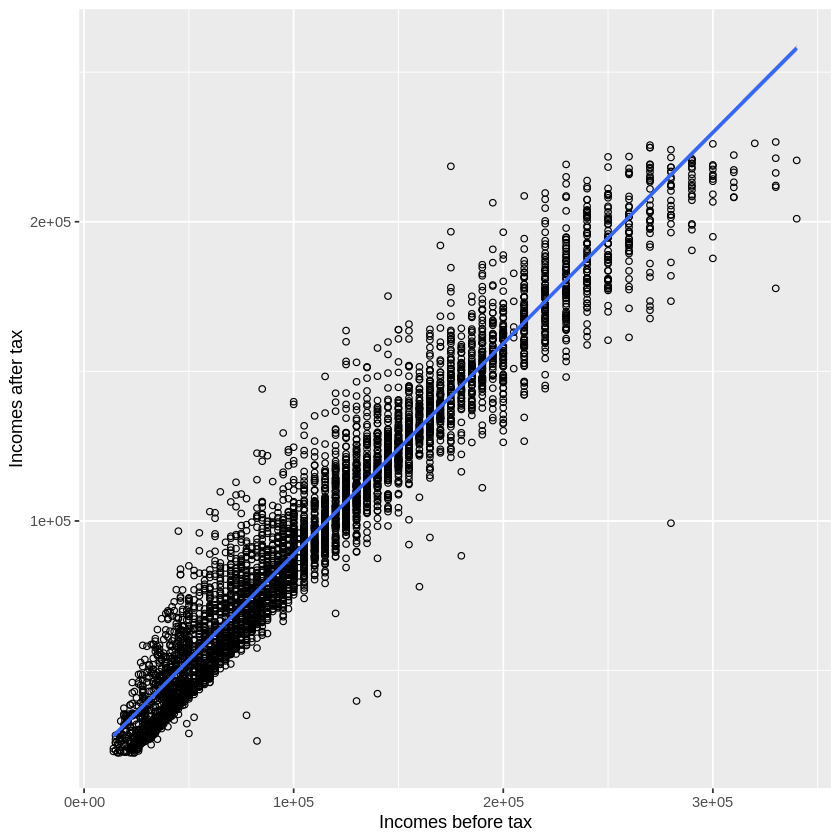

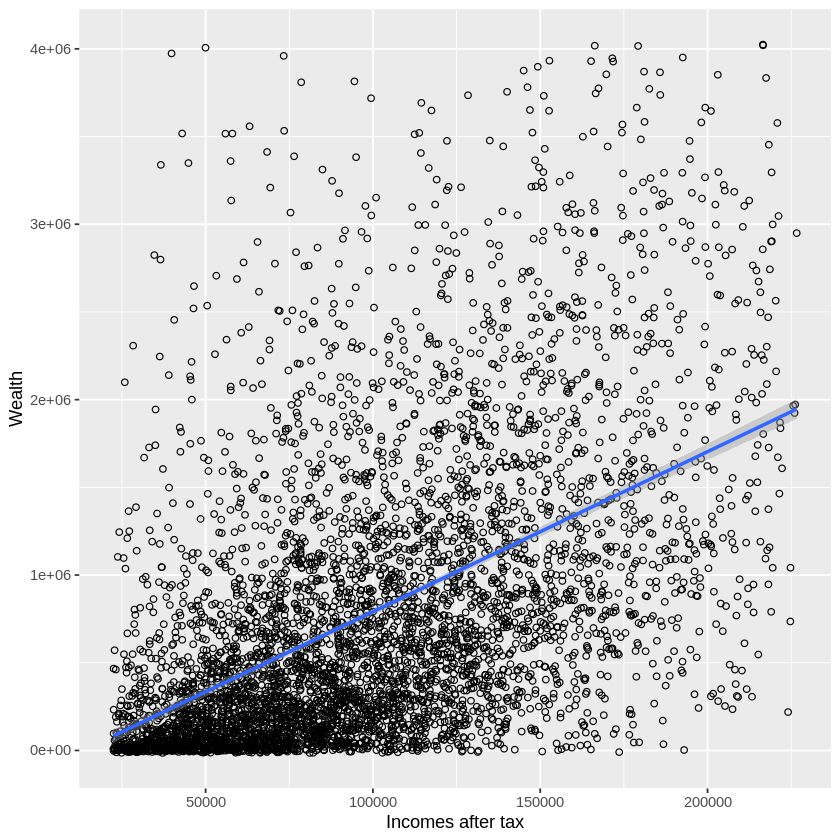

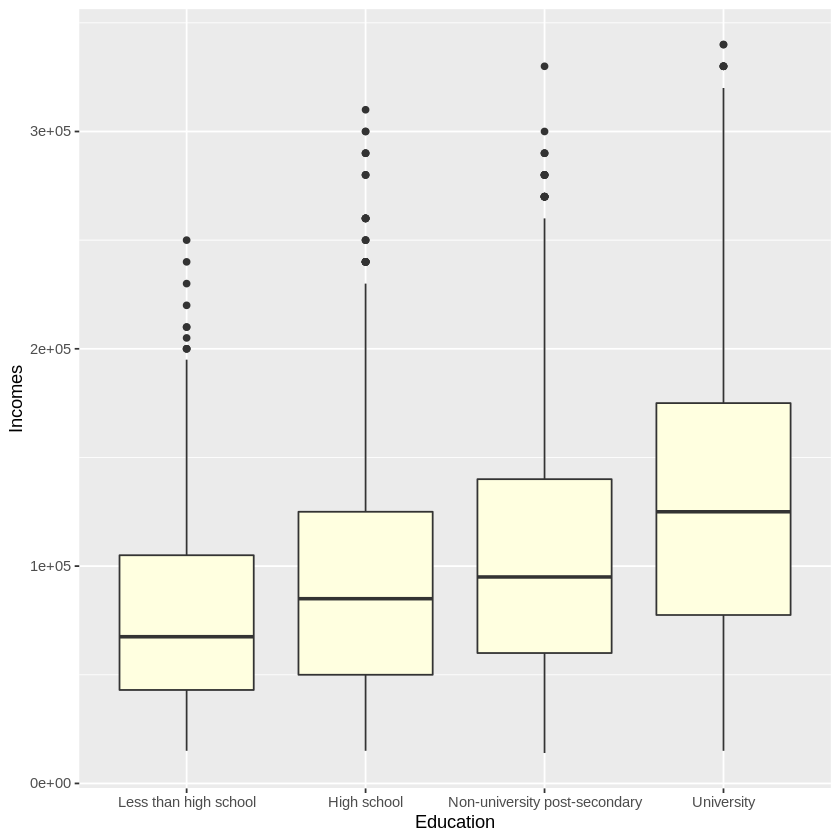

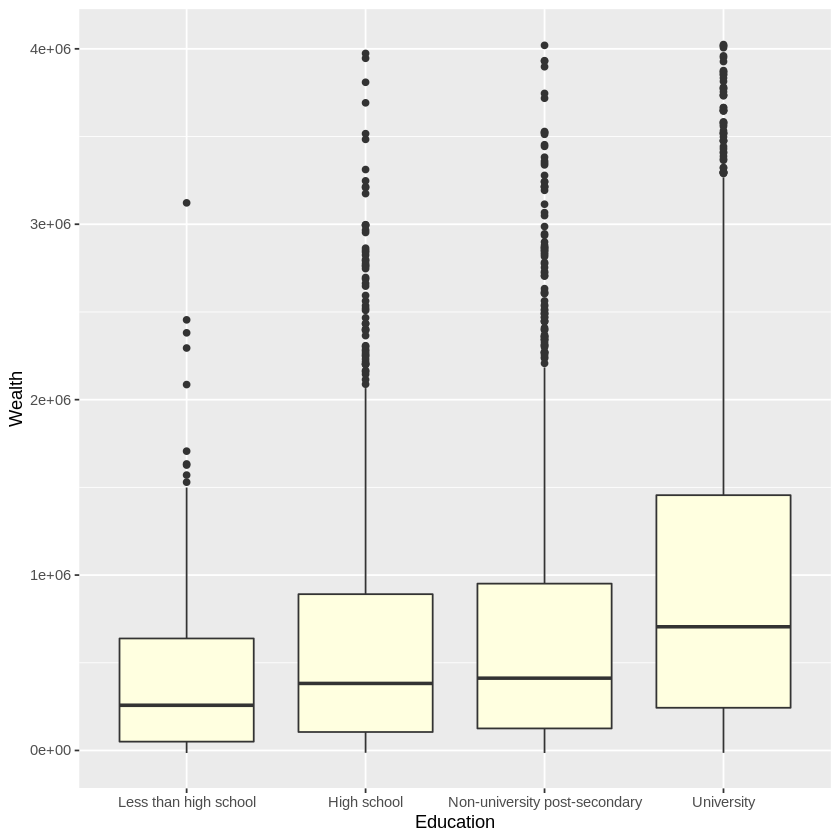

In [18]:
options(repr.plot.width=7,repr.plot.height=7)
before_after_tax<-ggplot(SFS_data, aes(x = income_before_tax, y = income_after_tax)) + 
    xlab("Incomes before tax") + ylab("Incomes after tax") +
    geom_point(shape = 1) + geom_smooth(method = lm, formula=y ~ x) + 
    scale_x_continuous() + scale_y_continuous() 
after_tax_wealth<-ggplot(SFS_data, aes(x = income_after_tax, y = wealth)) + 
    xlab("Incomes after tax") + ylab("Wealth") +
    geom_point(shape = 1) + geom_smooth(method = lm, formula=y ~ x) + 
    scale_x_continuous() + scale_y_continuous()
edu_before_tax <- ggplot(SFS_data, aes(x = education, y = income_before_tax)) + 
    xlab("Education") + ylab("Incomes") + geom_boxplot(fill = "lightyellow") + scale_y_continuous()
edu_wealth <- ggplot(SFS_data, aes(x = education, y = wealth)) + 
    xlab("Education") + ylab("Wealth") + geom_boxplot(fill = "lightyellow") + scale_y_continuous()

before_after_tax
after_tax_wealth
edu_before_tax
edu_wealth

Let's find out how large the correlations are between variables. We first transform `education` to be a numeric variable which increases as education increases. 

From table below, we know the correlations of education and incomes, and education and wealth are 0.26 and 0.21 respectively. This conforms with our previous results that incomes and wealth increase as education increases. But since correlations are not very close to 1, that means education is not the only factor to a successful career.

In [19]:
SFS_data$education<-as.numeric(SFS_data$education)
cor_data<-select(SFS_data, c('education','income_before_tax','income_after_tax','wealth'))
mydata.cor = cor(cor_data)
mydata.cor


,education,income_before_tax,income_after_tax,wealth
education,1.0000000,0.2633120,0.2405818,0.2065850
income_before_tax,0.2633120,1.0000000,0.9673971,0.5232641
income_after_tax,0.2405818,0.9673971,1.0000000,0.5159091
wealth,0.2065850,0.5232641,0.5159091,1.0000000


From the table and graphs above, we know there is positive correlations between education and incomes, as well as wealth. Are the correlations significantly different from 0? We will need hypothesis testing.

We perform Pearson correlation tests, and results suggest that correlations are significantly different from 0.

In [20]:
# Pearson correlation test
cor.test(SFS_data$education, SFS_data$income_before_tax, use="complete.obs") 
cor.test(SFS_data$education, SFS_data$wealth, use="complete.obs") 


	Pearson's product-moment correlation

data:  SFS_data$education and SFS_data$income_before_tax
t = 19.618, df = 5166, p-value < 2.2e-16
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 0.2377539 0.2885057
sample estimates:
     cor 
0.263312 



	Pearson's product-moment correlation

data:  SFS_data$education and SFS_data$wealth
t = 15.176, df = 5166, p-value < 2.2e-16
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 0.1803358 0.2325402
sample estimates:
     cor 
0.206585 


So far, we know that incomes and wealth increase as education increases. But there is one question which is not clear yet: is there another factor A that affects education and income at the same time, so that the real "force" that drives up income is factor A, rather than education? In order to answer this question, we can run regressions. Let's first change `education` back to a factor variable. 

In [21]:
SFS_data$education <- as.character(SFS_data$education)
SFS_data$education[SFS_data$education == "1"] <- "Less than high school"
SFS_data$education[SFS_data$education == "2"] <- "High school"
SFS_data$education[SFS_data$education == "3"] <- "Non-university post-secondary"
SFS_data$education[SFS_data$education == "4"] <- "University"
SFS_data$education <- as_factor(SFS_data$education)

In [22]:
regression1 <- lm(income_before_tax ~ education, data = SFS_data)
regression2 <- lm(income_before_tax ~ education + gender, data = SFS_data)
regression3 <- lm(income_before_tax ~ education + gender + agegr, data = SFS_data)

stargazer(regression1, regression2, regression3, title="Comparison of Controls",
          align = TRUE, type="text", keep.stat = c("n","rsq"))


Comparison of Controls
                                                   Dependent variable:            
                                       -------------------------------------------
                                                    income_before_tax             
                                            (1)           (2)            (3)      
----------------------------------------------------------------------------------
educationHigh school                   13,550.360*** 15,455.860***  17,298.760*** 
                                        (4,064.420)   (3,982.514)    (3,872.655)  
                                                                                  
educationNon-university post-secondary 24,357.410*** 27,703.390***  30,476.770*** 
                                        (3,905.314)   (3,831.245)    (3,738.480)  
                                                                                  
educationUniversity                    50,925.820*** 56,798.720

The table above displays results of 3 regressions. Column (1) shows the regression with education and incomes. The average income of households whose education is less than high school is CAD 81239.44. Average income of family with high school degree is CAD 81239.44 + CAD 13550.36 = CAD 94789.8. Similarly, we can calculate the average incomes of households with non-university post-secondary degree and university degree. They are exactly the same as what we have seen in two sample t-tests. So the first column suggests incomes increase as education increases. The second column includes education and gender in the regression. Compared with male-lead family, a family that has female as the main earner has less incomes. But the coefficient of `education` is still positive, significant and monotonically increasing, which means after controlling effects of gender, incomes still increase as education increases. Similarly, in the last column, we control gender and age group. We can see that people tend to earn more as they move on to later stages of their career. But again, the positive and monotonically increasing coefficients of education show the positive correlation between education and incomes. Since after we include other factors that may affect incomes, the coefficients of education are still positive and stable, we have stronger evidence that incomes increase as education increases.

## Going Further: Long-term Effect of Education
From previous results, we find that incomes and wealth increase as education increases. The next interesting question is whether there is long-term effects of education on career outcomes. In order to study this question, we explore returns to education for different age groups. It will be great that if we can study this question via panel data, but since we do not observe the same person across time periods, we study returns to education from different age groups.

We perform Welch two sample t-test for each age group. We study the difference between university degree holders and non-university post-secondary degree holders. We compare outcomes of age group 30s and 50s, which represents early stage and mature stage of career respectively.

We first study education impacts on incomes. For both groups, differences of incomes between university and non-university are significantly different from 0. Surprisingly, the income gap of 50s is about 3 times as the gap when they are in 30s.

As for wealth, wealth gaps between the two education groups increase even more when people enter a mature stage of their career. The wealth gap of 50s is more than 4 times as the gap when they are in 30s.

In [23]:
#Returns to education: University

##30s

retU = t.test(
       x = filter(SFS_data, (agegr == "30s" & education=='Non-university post-secondary'))$income_before_tax,
       y = filter(SFS_data, (agegr == "30s" & education=='University'))$income_before_tax,
       alternative = "two.sided",
       mu = 0,
       conf.level = 0.95)

retU
round(retU$estimate[2] - retU$estimate[1],2)

##50s

retUF = t.test(
       x = filter(SFS_data, (agegr == "50s" & education=='Non-university post-secondary'))$income_before_tax,
       y = filter(SFS_data, (agegr == "50s" & education=='University'))$income_before_tax,
       alternative = "two.sided",
       mu = 0,
       conf.level = 0.95)

retUF
round(retUF$estimate[2] - retUF$estimate[1],2)


	Welch Two Sample t-test

data:  filter(SFS_data, (agegr == "30s" & education == "Non-university post-secondary"))$income_before_tax and filter(SFS_data, (agegr == "30s" & education == "University"))$income_before_tax
t = -4.1221, df = 973.76, p-value = 4.074e-05
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 -21275.679  -7551.823
sample estimates:
mean of x mean of y 
 98545.66 112959.41 


mean of y 
 14413.75


	Welch Two Sample t-test

data:  filter(SFS_data, (agegr == "50s" & education == "Non-university post-secondary"))$income_before_tax and filter(SFS_data, (agegr == "50s" & education == "University"))$income_before_tax
t = -9.649, df = 1089.9, p-value < 2.2e-16
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 -44858.35 -29697.33
sample estimates:
mean of x mean of y 
 116223.0  153500.8 


mean of y 
 37277.84

In [24]:
#Returns to education: University

##30s

retU = t.test(
       x = filter(SFS_data, (agegr == "30s" & education=='Non-university post-secondary'))$wealth,
       y = filter(SFS_data, (agegr == "30s" & education=='University'))$wealth,
       alternative = "two.sided",
       mu = 0,
       conf.level = 0.95)

retU
round(retU$estimate[2] - retU$estimate[1],2)

##50s

retUF = t.test(
       x = filter(SFS_data, (agegr == "50s" & education=='Non-university post-secondary'))$wealth,
       y = filter(SFS_data, (agegr == "50s" & education=='University'))$wealth,
       alternative = "two.sided",
       mu = 0,
       conf.level = 0.95)

retUF
round(retUF$estimate[2] - retUF$estimate[1],2)


	Welch Two Sample t-test

data:  filter(SFS_data, (agegr == "30s" & education == "Non-university post-secondary"))$wealth and filter(SFS_data, (agegr == "30s" & education == "University"))$wealth
t = -3.7839, df = 961.73, p-value = 0.0001639
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 -183272.41  -58093.02
sample estimates:
mean of x mean of y 
 366716.2  487399.0 


mean of y 
 120682.7


	Welch Two Sample t-test

data:  filter(SFS_data, (agegr == "50s" & education == "Non-university post-secondary"))$wealth and filter(SFS_data, (agegr == "50s" & education == "University"))$wealth
t = -9.0266, df = 1089.8, p-value < 2.2e-16
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 -602866.7 -387570.9
sample estimates:
mean of x mean of y 
 971711.5 1466930.3 


mean of y 
 495218.8

## Summary
In this project, we study relationship between education and career. We use incomes and wealth as proxies for labor market outcomes. 

We first describe income and wealth distribution in Canadian households, and we find that there are income inequality and wealth inequality in Canada. 

Next, we study relationship between education and career outcomes via exploration of correlations, two sample t-test and regressions. Our results suggest that there are significant and positive correlation of education, incomes and wealth. We find that incomes and wealth increase as education increases. Thus education does help us to achieve a more successful career. Meanwhile, standard deviations of incomes and wealth also increase as education increases. This implies income and wealth inequality increase as education increases. 

Finally, we explore the long-term effects of education via studying return to education of different age groups. We find that income and wealth gaps increase dramatically for university degree holders and non-university degree counterparts when they enter later stage of career. This result implies that there is long-term effect of education on incomes and wealth.

To sum up, from a personal point of view, in order to have a successful career, obtaining a degree is important. But at the same time, career development is also crucial because education is not the only contributor to incomes. From a policy perspective, we need policies that target pre-labor market skill accumulation, as well as policies that foster career progression to reduce inequality.

### List of R Commands

In [ ]:
'Commands about Dataframe'

read_dta(file) #read dta files

!is.na(data) #return not NA data

filter(dataframe, conditions) #return dataframe that satisfies conditions, e.g.
SFS_data <- filter(SFS_data, !is.na(SFS_data$pefmtinc)) #return dataframe that variable pefmtinc is not NA

subset(dataframe, conditions) #select subset of dataframe that satisfies conditions, e.g.
SFS_data <- subset(SFS_data, pefmjsif == "02" | pefmjsif == "03") #select subset of dataframe that major income sources are salary or self-employment incomes

rename(dataframe, new name = old name) #rename variables in dataframe, e.g.
SFS_data <- rename(SFS_data, income_after_tax = pefatinc)

dataframe[order(data),] #sort dataframe according to a variable, e.g.
SFS_data <- SFS_data[order(SFS_data$education),]

mutate(new variable = [operation] existing variables) #adds new variables and preserves existing ones

case_when(conditions) #vectorise multiple if_else() statements

#e.g.
SFS_data <- 
        SFS_data %>%
        mutate(agegr = case_when(
              age == "01" ~ "Under 30", #under 20
              age == "02" ~ "Under 30", #20-24
              age == "03" ~ "20s", #25-29
              age == "04" ~ "30s",
            age == "05" ~ "30s",
              age == "06" ~ "40s",
              age == "07" ~ "40s",
              age == "08" ~ "50s",
              age == "09" ~ "50s",
              age == "10" ~ "60s", #60-64
              age == "11" ~ "Above 65", #65-69
              age == "12" ~ "Above 65", #70-74
              age == "13" ~ "Above 75", #75-79
              age == "14" ~ "Above 75", #80 and above
              )) %>% 
#create a new variable named `agegr` based on variable `age`. If age=="01", agegr will be "Under 30".

data.frame(variable=c(...),...) #create dataframe which contains variable, and we can define what's in the column with c()
#e.g.
df <- data.frame(variables=c('income before tax','income after tax','wealth'),
                 mean=round(c(mean(SFS_data$income_before_tax),mean(SFS_data$income_after_tax),mean(SFS_data$wealth)),2),
                 median=round(c(median(SFS_data$income_before_tax),median(SFS_data$income_after_tax),median(SFS_data$wealth)),2),
                sd=round(c(sd(SFS_data$income_before_tax),sd(SFS_data$income_after_tax),sd(SFS_data$wealth)),2))
#create a dataframe to contain variable names, means, medians and standard deviations.

select(dataframe, variables) #select columns from a dataframe, e.g.
cor_data<-select(SFS_data, c('education','income_before_tax','income_after_tax','wealth'))

length(data) #length of the vector

group_by(variable) #takes an existing tbl and converts it into a grouped tbl where operations are performed "by group"

summarize(variables) #creates a new data frame

#e.g.
results <- 
    SFS_data %>% 
    group_by(education) %>%
    summarize(m_income = mean(income_before_tax), sd_income = sd(income_before_tax),
              m_wealth = mean(wealth), sd_wealth = sd(wealth))
#convert SFS_data to a grouped table, grouped by `education`. make a new table with means, standard deviations of each group

In [ ]:
'Commands about Types'

as.numeric(data) #transform strings to numbers, e.g.
SFS_data$education <- as.numeric(SFS_data$education)

as.character(data) #transform numbers to strings, e.g.
SFS_data$education <- as.character(SFS_data$education)

as_factor(data) #transform strings to factor variables, e.g.
SFS_data$gender <- as_factor(SFS_data$gender)

factor(factor variable,levels = c("A", "B", "C", "D", "E")) #order factor variable, e.g.
SFS_data$agegr <- factor(SFS_data$agegr,levels = c("20s", "30s", "40s", "50s", "60s"))

In [ ]:
'Commands about Calculation'

round(data, number of digits) #round numbers to have certain number of digits

sqrt(n) #square root of n

In [ ]:
'Commands about Summary Statistics'

mean(data) #mean of data

median(data) #median of data

sd(data) #standard deviation of data 

quantile(data, vector of probabilities) #produces sample quantiles corresponding to the given probabilities, e.g.
pct2_income_before <- quantile(SFS_data$income_before_tax,c(0.02,0.98),type=1)
#sample quantiles of 0.02 and 0.98 of income_before_tax

cor(data) #correlations of variables

qt(p = 0.05, df = df) #return t statistics with confidence level of 95% and degree of freedom of df

In [ ]:
'Commands about Plots'

ggplot(data,options) #create plots, e.g.

age_plot<-ggplot(SFS_data, aes(x=factor(agegr))) + geom_bar(fill="lightblue") + xlab("Age Groups") + theme(axis.text.x = element_text(angle = 90))
#create bar plot for factor varible `agegr`, with color lightblue, with texts display vertically

income_before_tax_plot<-ggplot(SFS_data, aes(x=income_before_tax)) + geom_histogram()  + xlab("Income before Tax") + ylab("Number of Observations")
#create histogram for `income_before_tax`, with labels of x-axis and y-axis

before_after_tax<-ggplot(SFS_data, aes(x = income_before_tax, y = income_after_tax)) + geom_point(shape = 1) + geom_smooth(method = lm)
#create scatter plot with a regression line

ggarrange(plots, ncol=number of columns, nrow = number of rows) #arrange plots, e.g
ggarrange(income_before_tax_plot,income_after_tax_plot,  ncol = 2, nrow = 1) # arrange 2 plots in the same row

corrplot(mydata.cor) #plot correlations

In [ ]:
'define a function named `CI`, input `data`, output `bound`'

CI <- function(data) {
    ...
    return(bound)
}

In [ ]:
'Commands about Tests'

t.test(x, y, alternative = c("two.sided", "less", "greater"),
       mu = 0, paired = FALSE, var.equal = FALSE,
       conf.level = 0.95, …) #Performs one and two sample t-tests on vectors of data.

cor.test(x, y, use="complete.obs") #Test for association between paired samples, using one of Pearson's product moment correlation coefficient

In [ ]:
'Commands about Regressions'

lm(dependent variable ~ independent variable, data) #run a regression

stargazer(regression1, regression2, regression3, ...) #show several regression results in a table

### Quick Note on Commands

It's important to remember that you may need to use these commands in ways that aren't specified above. For example, you may want to use the `t_test` function with a different confidence level, so you may set `conf.level = 0.99`. You may also have to add new parameters depending on what you are trying to accomplish. For example, to run a linear regression with a subset of the data, you would need to add a `subset` parameter to the `lm` function. To discover what each of the functions can do, check out the R documentation for the functions to get a detailed list of the different parameters and default values you can use for function. 

https://www.rdocumentation.org/